In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
import keras
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

from sklearn.metrics import mean_squared_error

import math

import matplotlib.dates as mdates
import matplotlib.cbook as cbook

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Download TD Bank historical stock price data from yahoo finance (NYSE).

In [124]:
# Define the instruments to download
tickers = ['TD']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2009-04-18'
end_date = '2019-04-18'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('TD', 'yahoo', start_date, end_date)

In [125]:
panel_data.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-04-20,19.785000,18.965000,19.785000,19.014999,3096600.0,10.288013
2009-04-21,19.565001,18.350000,18.915001,19.504999,4439200.0,10.553122
2009-04-22,19.670000,19.105000,19.195000,19.105000,3628600.0,10.336704
2009-04-23,19.834999,19.209999,19.350000,19.834999,3540400.0,10.731671
2009-04-24,20.264999,19.799999,20.049999,20.049999,3954800.0,10.847995


Getting just the adjusted closing prices.

In [126]:
data_close = panel_data['Close']

In [127]:
data_close.head(5)

Date
2009-04-20    19.014999
2009-04-21    19.504999
2009-04-22    19.105000
2009-04-23    19.834999
2009-04-24    20.049999
Name: Close, dtype: float64

Getting all weekdays between '2009-04-18' and '2019-04-18'

In [128]:
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

How do we align the existing prices in adj_close with our new set of dates?

All we need to do is reindex close using all_weekdays as the new index

In [129]:
data_close = data_close.reindex(all_weekdays)

Reindexing will insert missing values (NaN) for the dates that were not present
in the original set. To cope with this, we can fill the missing by replacing them
with the latest available price for each instrument.

In [130]:
data_close = data_close.fillna(method='ffill')

In [131]:
print(all_weekdays)

DatetimeIndex(['2009-04-20', '2009-04-21', '2009-04-22', '2009-04-23',
               '2009-04-24', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01',
               ...
               '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10',
               '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16',
               '2019-04-17', '2019-04-18'],
              dtype='datetime64[ns]', length=2609, freq='B')


In [132]:
data_close.head(5)

2009-04-20    19.014999
2009-04-21    19.504999
2009-04-22    19.105000
2009-04-23    19.834999
2009-04-24    20.049999
Freq: B, Name: Close, dtype: float64

In [133]:
data_close.describe()

count    2609.000000
mean       43.647915
std         8.296066
min        19.014999
25%        38.544998
50%        42.540001
75%        49.450001
max        61.820000
Name: Close, dtype: float64

Suppose we would like to plot the MSFT time-series. We would also like to see how the stock behaves compared to a short and longer term moving average of its price.

A simple moving average of the original time-series is calculated by taking for each date the average of the last W prices (including the price on the date of interest). pandas has rolling(), a built in function for Series which returns a rolling object for a user-defined window, e.g. 20 days.

Once a rolling object has been obtained, a number of functions can be applied on it, such as sum(), std() (to calculate the standard deviation of the values in the window) or mean(). See below:

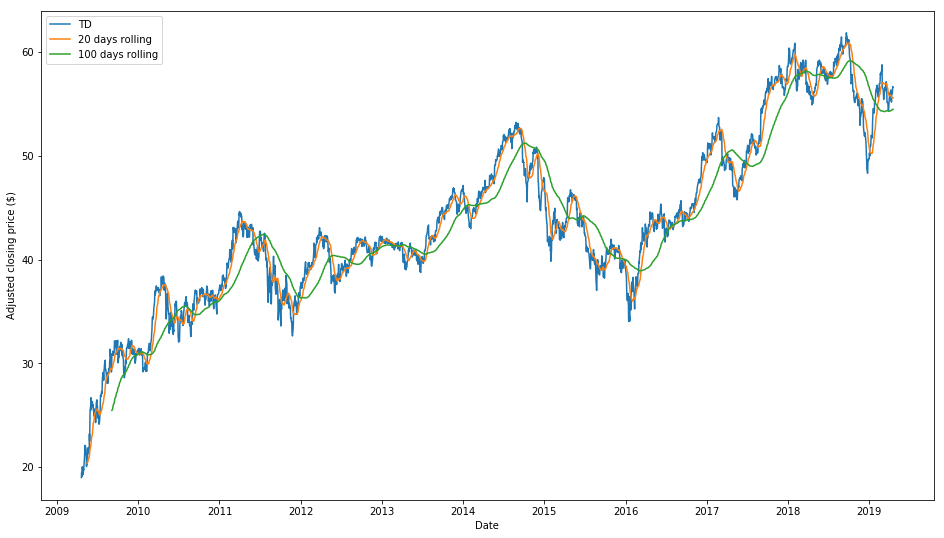

In [134]:
# Get the TD timeseries. This now returns a Pandas Series object indexed by date.

# Calculate the 20 and 100 days moving averages of the closing prices
short_rolling_td = data_close.rolling(window=20).mean()
long_rolling_td = data_close.rolling(window=100).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data_close.index, data_close, label='TD')
ax.plot(short_rolling_td.index, short_rolling_td, label='20 days rolling')
ax.plot(long_rolling_td.index, long_rolling_td, label='100 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

# TD Deep Learning Analysis

In [135]:
row_index = list(data_close.index.values)

In [136]:
data_close = np.array(data_close)

In [137]:
data_close

array([19.01499939, 19.50499916, 19.10499954, ..., 56.5       ,
       56.63999939, 56.56000137])

In [138]:
data_close = np.reshape(data_close, (-1, 1))

In [139]:
data_close

array([[19.01499939],
       [19.50499916],
       [19.10499954],
       ...,
       [56.5       ],
       [56.63999939],
       [56.56000137]])

In [146]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_close = scaler.fit_transform(data_close)

In [147]:
data_close

array([[0.        ],
       [0.01144726],
       [0.00210256],
       ...,
       [0.87571546],
       [0.87898609],
       [0.8771172 ]])

In [148]:
data_close = np.reshape(data_close, (-1,1))

In [149]:
data_close.shape

(2609, 1)

In [150]:
data_close

array([[0.        ],
       [0.01144726],
       [0.00210256],
       ...,
       [0.87571546],
       [0.87898609],
       [0.8771172 ]])

In [151]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.75

train_size = int(data_close.shape[0] * TRAIN_SIZE)
test_size = data_close.shape[0] - train_size
train, test = data_close[0:train_size], data_close[train_size:data_close.shape[0]]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1956, 653)


In [152]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size)]
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.reshape(np.array(data_X), (-1, 1)), np.array(data_Y))

In [153]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)
print("Original testing data shape:")
print(test_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

print("New testing data shape:")
print(test_X.shape)

Original training data shape:
(1954, 1)
Original testing data shape:
(651, 1)
New training data shape:
(1954, 1, 1)
New testing data shape:
(651, 1, 1)


In [154]:
def fit_model(train_X, train_Y, window_size = 5):
    model = Sequential()
    model.add(InputLayer(input_shape = (1, window_size)))
    model.add(LSTM(units = 10))
    #ropout(0.15)
    model.add(Dense(1, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
 - 10s - loss: 0.0146
Epoch 2/100
 - 7s - loss: 2.6755e-04
Epoch 3/100
 - 6s - loss: 1.6545e-04
Epoch 4/100
 - 6s - loss: 1.6538e-04
Epoch 5/100
 - 6s - loss: 1.6682e-04
Epoch 6/100
 - 7s - loss: 1.6250e-04
Epoch 7/100
 - 8s - loss: 1.5626e-04
Epoch 8/100
 - 6s - loss: 1.5874e-04
Epoch 9/100
 - 6s - loss: 1.5792e-04
Epoch 10/100
 - 6s - loss: 1.5906e-04
Epoch 11/100
 - 6s - loss: 1.5481e-04
Epoch 12/100
 - 6s - loss: 1.5593e-04
Epoch 13/100
 - 6s - loss: 1.5676e-04
Epoch 14/100
 - 7s - loss: 1.5985e-04
Epoch 15/100
 - 6s - loss: 1.5869e-04
Epoch 16/100
 - 8s - loss: 1.5673e-04
Epoch 17/100
 - 9s - loss: 1.5685e-04
Epoch 18/100
 - 7s - loss: 1.5650e-04
Epoch 19/100
 - 8s - loss: 1.5592e-04
Epoch 20/100
 - 8s - loss: 1.5478e-04
Epoch 21/100
 - 9s - loss: 1.5518e-04
Epoch 22/100
 - 6s - loss: 1.5351e-04
Epoch 23/100
 - 6s - loss: 1.5603e-04
Epoch 24/100
 - 7s - loss: 1.5455e-04
Epoch 25/100
 - 6s - loss: 1.5365e-04
Epoch 26/100
 - 6s - loss: 1.5541e-04
Epoch 27/100
 - 6s - los

In [155]:
#model_pred = model1.predict(train_X)

In [156]:
#model_pred.shape

In [157]:
#pred = scaler.inverse_transform(model_pred)

In [158]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred_not_inversed = model.predict(X)
    print(pred_not_inversed.shape)
    pred = scaler.inverse_transform(pred_not_inversed) # DO NOT DELETE!
    print(pred.shape)
    #print(pred.shape)
    # Prepare Y data to also be on the original scale for interpretability.
    #print(Y.shape)
    orig_data = scaler.inverse_transform(Y)
    #print(orig_data)
    # Calculate RMSE.
    # score = math.sqrt(mean_squared_error(Y, pred[:, 0])) DO NOT DELETE!
    score = math.sqrt(mean_squared_error(orig_data, pred)) #DO NOT DELETE!
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

(1954, 1)
(1954, 1)
(651, 1)
(651, 1)
Training data score: 0.50 RMSE
Test data score: 0.50 RMSE


In [159]:
new_row_index = []
for i in range(len(row_index)):
    if i%50 == 0:
        new_row_index.append(row_index[i])
    else:
        new_row_index.append('')

In [161]:
x_axis = [i for i in range(len(list(data_close)))]

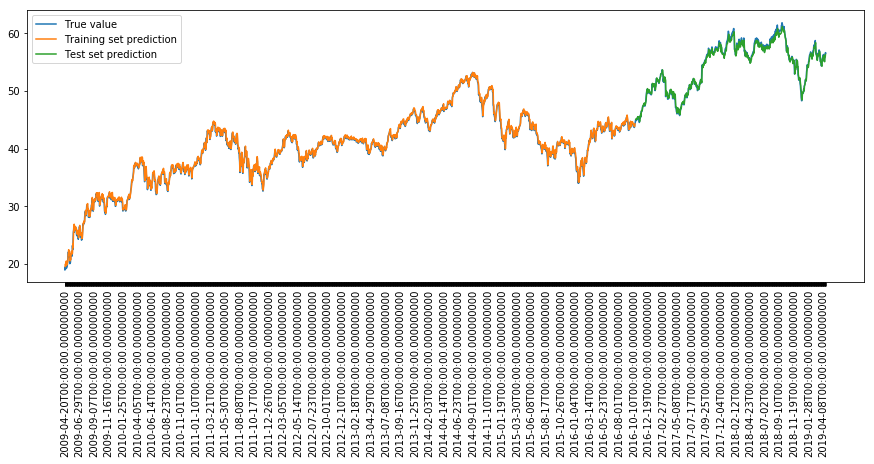

In [162]:
# Start with training predictions.
train_predict_plot = np.empty_like(list(data_close))
train_predict_plot[:] = np.NaN
train_predict_plot[window_size:len(train_predict) + window_size] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(list(data_close))
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(data_close) - 1] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(list(data_close)), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.legend()
plt.xticks(x_axis, new_row_index, rotation='vertical')
#plt.xticks(x_axis, np.arange(min(row_index), max(row_index)+1, time_delta), rotation='vertical') # DO NOT DELETE!
#plt.xticks(x_axis, np.arange(min(row_index), max(row_index)+1, np.timedelta64('1', 'M'), dtype='datetime64[M]').astype('datetime64[M]'), rotation='vertical')
#plt.tight_layout()
#plt.grid()
plt.show()

Sources used:

https://learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

https://medium.com/analytics-vidhya/introduction-to-neural-networks-for-finance-6abd5675e497